In [103]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

from lisfloodreservoirs import Config, read_attributes, read_timeseries
from lisfloodreservoirs.calibration import read_results

## Configuration

In [66]:
path_tests = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/v2.1/test')
cfg = Config(path_tests / 'camaflood_2var_1000_8ngs.yml')

In [87]:
runs = [
    # '1000_4',
    '1000_8',
    '2000_4',
    '2000_8',
    '10000_16'
]

In [88]:
subpath_calib = Path('camaflood/calibration/bivariate')

## Data

### Reservoirs

In [89]:
# list of reservoirs to be trained
reservoir_list = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

### Calibration

## Analysis

In [102]:
results = {grand_id: {} for grand_id in reservoir_list}
for grand_id, dct in tqdm(results.items(), desc='reservoirs'):
    for run in runs:
        path = path_tests / run / subpath_calib
        file = path / f'{grand_id}_samples.csv'
        iterations, parameters = read_results(file)
        iterations['KGE'] = 1 - iterations.like1
        iterations.drop('like1', axis=1, inplace=True)
        dct[run] = iterations

  1000_8	KGE = 0.047 (iteration 381)
  2000_4	KGE = 0.049 (iteration 556)
  2000_8	KGE = 0.046 (iteration 169)
10000_16	KGE = 0.049 (iteration 513)


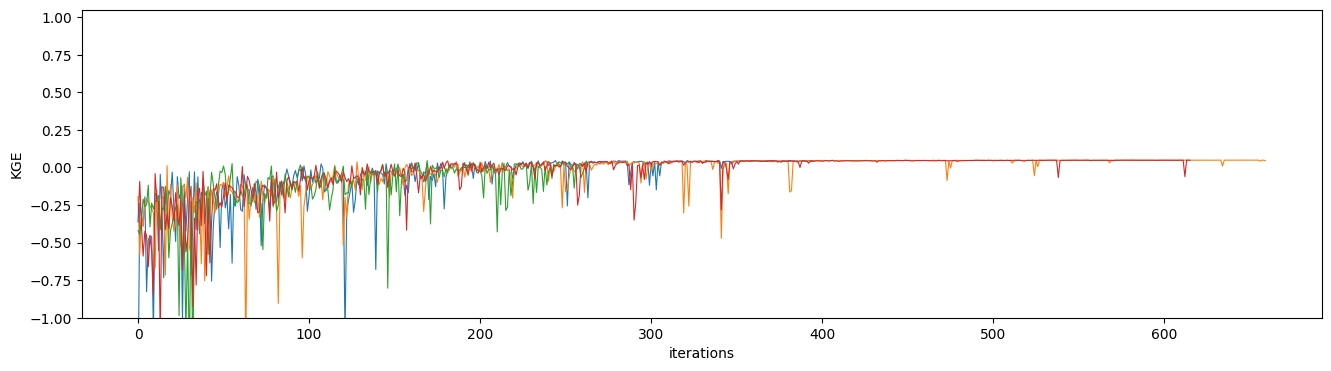

In [92]:
grand_id = 41

fig, ax = plt.subplots(figsize=(16, 4))
ax.set(
    xlabel='iterations',
    ylabel='KGE',
    ylim=(-1, 1.05)
)

for run, iterations in results[grand_id].items():
    iter_best, kge_best = iterations.KGE.idxmax(), iterations.KGE.max()
    print('{0:>8}\tKGE = {1:.3f} (iteration {2})'.format(run, kge_best, iter_best))
    ax.plot(iterations.KGE, lw=.8, label='run')

In [104]:
summary = pd.DataFrame(index=reservoir_list, columns=runs)
for grand_id, dct in results.items():
    for run, iterations in dct.items():
        summary.loc[grand_id, run] = iterations.KGE.max()

In [107]:
import seaborn as sns

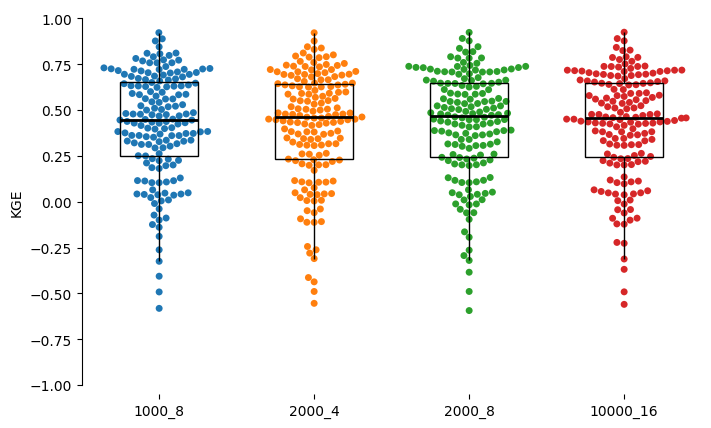

In [148]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    summary,
    width=.5,
    showcaps=False,
    showfliers=False,
    boxprops=dict(facecolor='none', edgecolor='k', linewidth=1),
    whiskerprops=dict(color='k', linewidth=1),
    medianprops=dict(color='k', linewidth=2),
    zorder=2,
    ax=ax
)
sns.swarmplot(summary, ax=ax, zorder=1)
ax.set(
    ylim=(-1.05, 1.05),
    ylabel='KGE'
)
ax.spines['left'].set_bounds([-1, 1])
ax.spines[['top', 'right', 'bottom']].set_visible(False)

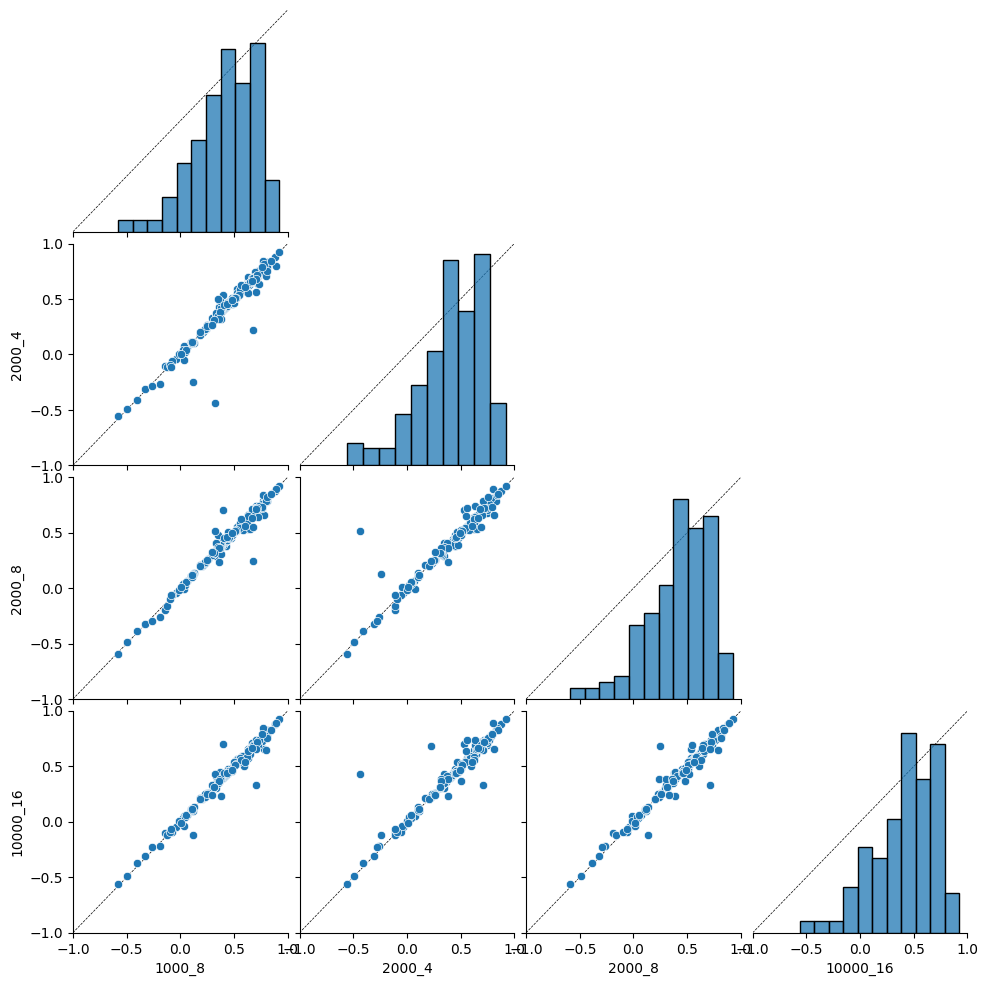

In [133]:
pp = sns.pairplot(
    summary,
    corner=True,
)

vlim = (-1, 1)
for ax in pp.axes.flat:
    if ax is not None: # Check if the axis object exists (corner=True leaves some empty)
        ax.plot(vlim, vlim, c='k', ls='--', lw=.5, zorder=0)
        ax.set(
            xlim=vlim,
            ylim=vlim
            )

In [149]:
(summary['10000_16'] - summary['2000_4']).sort_values(ascending=False)

1723    0.865912
1754    0.465626
974     0.171243
893     0.169254
1207    0.121501
          ...   
458    -0.092037
1254   -0.133394
1028   -0.150278
620    -0.152185
193    -0.375675
Length: 164, dtype: object

In [124]:
pd.concat([summary.idxmin(), summary.min()], axis=1)

,0,1
1000_8,789,-0.581369
2000_4,789,-0.553941
2000_8,789,-0.59341
10000_16,789,-0.559551


In [125]:
summary.mean()

1000_8      0.418792
2000_4      0.412302
2000_8      0.418321
10000_16    0.418595
dtype: object

In [120]:
summary.median()

1000_8      0.447582
2000_4      0.462036
2000_8       0.46742
10000_16    0.456667
dtype: object

In [126]:
pd.concat([summary.idxmax(), summary.max()], axis=1)

,0,1
1000_8,612,0.922366
2000_4,612,0.921849
2000_8,612,0.923891
10000_16,612,0.92496
